# High Dimensional Fixed Effects with Rossman Sales Data

**Intro**

This tutorial demonstrates how you can create models with high dimensional fixed effects using `quantcore.glm`. Thanks to the utilization of `quantcore.matrix`, we can pass categorical variables with a large range of values and the rest is taken care of for us. `quantcore.glm` and `quantcore.matrix` will handle the creation of the one-hot-encoded design matrix and also take advantage of the sparse nature of the matrix to optimize operations.


**Background**

For this tutorial, we will be predicting sales for the European drug store chain. Specifically, we are tasked with predicting daily sales for future dates. Ideally, we want a model that can capture the many factors that influence stores sales -- promotions, competition, school, holidays, seasonality, etc. As a baseline, we will start with a simple model that only uses a few basic predictors. Then, we will fit a model with a large number of fixed effects.

*Note*: a few parts of this tutorial utilize local helper functions outside this notebook. If you wish to run the notebook on your own, you can find the rest of the code here: <span style="color:red">**TODO**: add link once in master</span>.

## Table of Contents <a class="anchor" id="toc"></a>
* [1. Data Loading and Feature Engineering](#1-load)
* [2. Fit Baseline GLM Model](#2-baseline)
* [3. GLM with High Dimensional Fixed Effects](#3-highdim)
* [4. Plot Results](#4-plot)

In [1]:
import os
from pathlib import Path

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dask_ml.impute import SimpleImputer
from dask_ml.preprocessing import Categorizer
from quantcore.glm import GeneralizedLinearRegressor
from sklearn.pipeline import Pipeline

from feature_engineering import apply_all_transformations
from metrics import root_mean_squared_percentage_error
from process_data import load_test, load_train, process_data

pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option('display.max_columns', None)
alt.data_transformers.enable("json")  # to allow for large plots

DataTransformerRegistry.enable('json')

## 1. Data Loading and Feature Engineering<a class="anchor" id="1-load"></a>
[back to table of contents](#toc)

We start by loading in the raw data. If you have not yet processed the raw data, it will be done below. (Initial processing consists of some basic cleaning and renaming of columns.

*Note*: if you wish to run this notebook on your own, and have not done so already, please download the data from the [Rossman Kaggle Challenge](https://www.kaggle.com/c/rossmann-store-sales). This tutorial expects that it in a folder names "raw_data" under the same directory as the notebook.

### 1.1 Load

In [2]:
if not all([os.path.exists(p) for p in ["raw_data/train.csv", "raw_data/test.csv", "raw_data/store.csv"]]):
    raise Exception("Please download raw data into 'raw_data' folder")

if not all([os.path.exists(p) for p in ["processed_data/train.parquet", "processed_data/test.parquet"]]):
    "Processed data not found. Processing data from raw data..."
    process_data()
    "Done"
    
df = load_train().sort_values(["store", "date"])
df = df.iloc[:int(.1*len(df))]
df.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,year,month,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
1016095,1,2,2013-01-01,0,0,False,0,a,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None
1014980,1,3,2013-01-02,5530,668,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None
1013865,1,4,2013-01-03,4327,578,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None
1012750,1,5,2013-01-04,4486,619,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None
1011635,1,6,2013-01-05,4997,635,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None


### 1.2 Feature Engineering

As we mention earlier, we want our model to incorporate the many factors that influence store sales. Thus, we create a number of fixed effects to capture this information. These include:

- Fixed effects for a certain number days before a school or state holidays
- Fixed effects for a certain number days after a school or state holidays
- Fixed effects for a certain number days before a promo
- Fixed effects for a certain number days after a promo
- Fixed effects for a certain number days before the store is open or closed
- Fixed effects for a certain number days after the store is open or closed
- Fixed effects for each month for each store
- Fixed effects for each year for each store
- Fixed effects for each day of the week for each store

In addition to fixed effects, we also do several other transformations including taking the log of sales. We will use this instead of raw sales to account for skewed data.

In [3]:
df = apply_all_transformations(df)
df.head()

/Users/mabasta/opt/anaconda3/envs/quantcore.glm/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,year,month,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,age_quantile,competition_open,count,log_sales,open_lag_1,open_lag_2,open_lag_3,open_lead_1,open_lead_2,open_lead_3,promo_lag_1,promo_lag_2,promo_lag_3,promo_lead_1,promo_lead_2,promo_lead_3,school_holiday_lag_1,school_holiday_lag_2,school_holiday_lag_3,school_holiday_lead_1,school_holiday_lead_2,school_holiday_lead_3,state_holiday_lag_1,state_holiday_lag_2,state_holiday_lag_3,state_holiday_lead_1,state_holiday_lead_2,state_holiday_lead_3,store_day_of_week,store_month,store_school_holiday,store_state_holiday,store_year,zscore
1016095,1,2,2013-01-01,0,0,False,0,a,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None,-1,1.000,0,-inf,1.0,1.0,1.0,True,True,True,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0,0,0,0,0,0,1_2,1_1,1_1,1_True,1_2013,NaN
1014980,1,3,2013-01-02,5530,668,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None,-1,1.000,1,8.618,False,1.0,1.0,True,True,True,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,1.000,1.000,a,0,0,0,0,0,1_3,1_1,1_1,1_False,1_2013,NaN
1013865,1,4,2013-01-03,4327,578,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None,-1,1.000,2,8.373,True,False,1.0,True,True,False,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,1.000,1.000,0,a,0,0,0,0,1_4,1_1,1_1,1_False,1_2013,NaN
1012750,1,5,2013-01-04,4486,619,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None,-1,1.000,3,8.409,True,True,False,True,False,True,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0,0,a,0,0,0,1_5,1_1,1_1,1_False,1_2013,NaN
1011635,1,6,2013-01-05,4997,635,True,0,0,1,2013,1,c,a,1270.000,9.000,2008.000,0,NaN,NaN,None,-1,1.000,4,8.517,True,True,True,False,True,True,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,0,0,0,0,0,0,1_6,1_1,1_1,1_False,1_2013,NaN


### 1.3 Train vs. Validation selection

Lastly, we split our data into training and validation sets. Kaggle provides a test set for the Rossman challenge, but it does not directly include outcome data (sales), so we do not use it for our tutorial. Instead, we simulate predicting future sales by taking the last 5 months of our training data as our validation set. 

In [4]:
validation_window = [pd.to_datetime("2015-03-15"), pd.to_datetime("2015-07-31")]
select_train = (df["sales"].gt(0) & df["date"].lt(validation_window[0]) & df["zscore"].abs().lt(5)).to_numpy()

select_val = (
    df["sales"].gt(0)
    & df["date"].ge(validation_window[0])
    & df["date"].lt(validation_window[1])
).to_numpy()


(select_train.sum(), select_val.sum())

(57876, 12502)

## 2. Fit Baseline GLM Model<a class="anchor" id="2-baseline"></a>
[back to table of contents](#toc)


In [5]:
baseline_features = ["year", "month", "day_of_week", "store"]
baseline_categorizer = Categorizer(columns=baseline_features)
baseline_glm = GeneralizedLinearRegressor(
    family="normal",
    scale_predictors=True,
    l1_ratio=0.0,
    alphas=[1e-1],
)

In [6]:
baseline_glm.fit(
    baseline_categorizer.fit_transform(df[select_train][baseline_features]),
    df.loc[select_train, "log_sales"]
)

df.loc[lambda x: x["open"], "predicted_log_sales_baseline"] = baseline_glm.predict(
    baseline_categorizer.fit_transform(df.loc[lambda x: x["open"]][baseline_features])
)

df["predicted_log_sales_baseline"] = df["predicted_log_sales_baseline"].fillna(0)
df["predicted_sales_baseline"] = np.exp(df["predicted_log_sales_baseline"])

In [7]:
root_mean_squared_percentage_error(
    df.loc[select_val, "sales"], df.loc[select_val, "predicted_sales_baseline"]
)

30.127697751891645

## 3. GLM with High Dimensional Fixed Effects<a class="anchor" id="3-highdim"></a>
[back to table of contents](#toc)

In [8]:
highdim_features = [
    "age_quantile",
    "competition_open",
    "open_lag_1",
    "open_lag_2",
    "open_lag_3",
    "open_lead_1",
    "open_lead_2",
    "open_lead_3",
    "promo_lag_1",
    "promo_lag_2",
    "promo_lag_3",
    "promo_lead_1",
    "promo_lead_2",
    "promo_lead_3",
    "promo",
    "school_holiday_lag_1",
    "school_holiday_lag_2",
    "school_holiday_lag_3",
    "school_holiday_lead_1",
    "school_holiday_lead_2",
    "school_holiday_lead_3",
    "school_holiday",
    "state_holiday_lag_1",
    "state_holiday_lag_2",
    "state_holiday_lag_3",
    "state_holiday_lead_1",
    "state_holiday_lead_2",
    "state_holiday_lead_3",
    "state_holiday",
    "store_day_of_week",
    "store_month",
    "store_school_holiday",
    "store_state_holiday",
    "store_year",
]
highdim_categorizer = Pipeline([
    ("categorize", Categorizer(columns=highdim_features)),
    ("impute", SimpleImputer(strategy="most_frequent"))
])
highdim_glm = GeneralizedLinearRegressor(
    family="normal",
    scale_predictors=True,
    l1_ratio=0.0, # only ridge
    #alpha=[1e-4, 1e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1, 10],
    alpha_search=True,
)

In [9]:
highdim_glm.fit(
    highdim_categorizer.fit_transform(df[select_train][highdim_features]),
    df.loc[select_train, "log_sales"]
)

GeneralizedLinearRegressor(alpha_search=True, l1_ratio=0.0,
                           scale_predictors=True)

In [10]:
df.loc[lambda x: x["open"], "predicted_log_sales_highdim"] = highdim_glm.predict(
    highdim_categorizer.transform(df.loc[lambda x: x["open"]][highdim_features]),
)

df["predicted_log_sales_highdim"] = df["predicted_log_sales_highdim"].fillna(0)
df["predicted_sales_highdim"] = np.exp(df["predicted_log_sales_highdim"])

root_mean_squared_percentage_error(
    df.loc[select_train, "sales"], df.loc[select_train, "predicted_sales_highdim"]
)

13.580818755303238

## 4. Plot Results<a class="anchor" id="4-plot"></a>
[back to table of contents](#toc)

In [11]:
sales_cols = ["sales", "predicted_sales_highdim", "predicted_sales_baseline"]

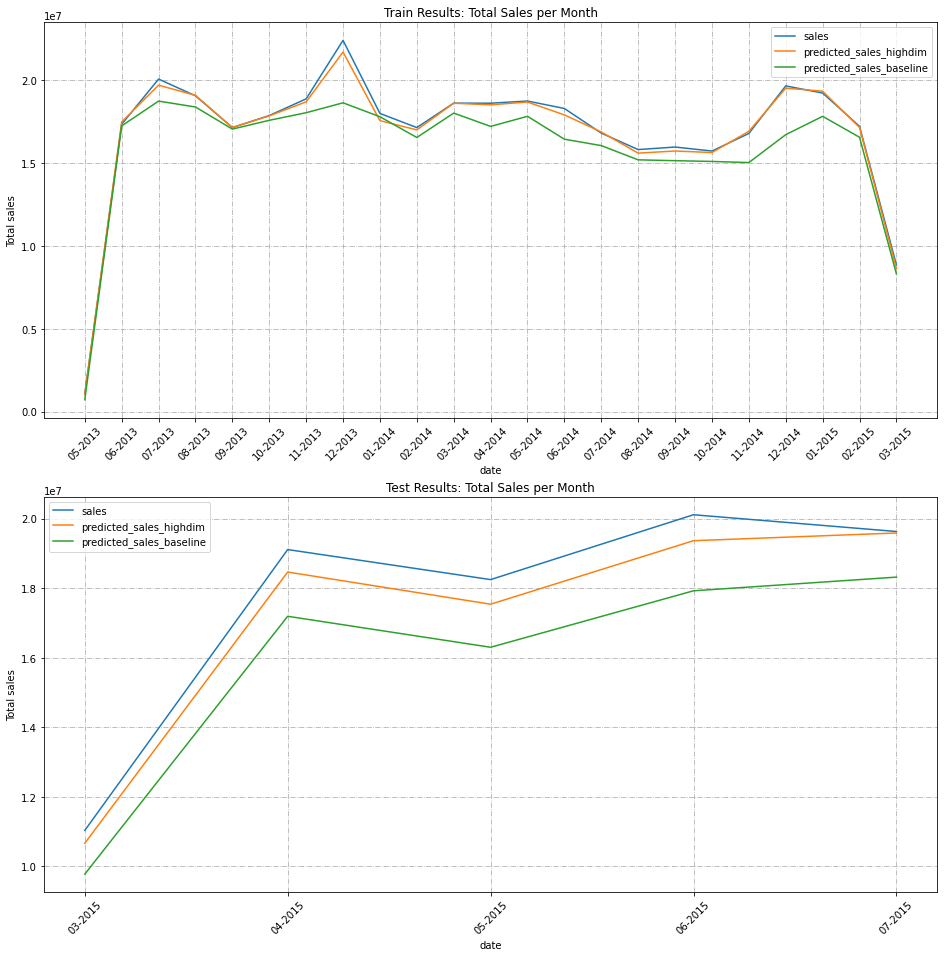

In [12]:
_, axs = plt.subplots(2, 1, figsize=(16, 16))

for i, select in enumerate([select_train, select_val]):
    ax = axs[i]
    df_plot_date = df[select].groupby(
        ["year", "month"]
    ).agg("sum")[sales_cols].reset_index()

    year_month_date = df_plot_date['month'].map(str)+ '-' + df_plot_date['year'].map(str)
    df_plot_date['year_month'] = pd.to_datetime(year_month_date, format='%m-%Y').dt.strftime('%m-%Y')
    df_plot_date.drop(columns= ["year", "month"], inplace=True)

    df_plot_date.plot(x="year_month", ax=ax)
    ax.set_xticks(range(len(df_plot_date)))
    ax.set_xticklabels(df_plot_date.year_month, rotation=45)
    ax.set_xlabel("date")
    ax.set_ylabel("Total sales")
    ax.grid(True, linestyle='-.')

axs[0].set_title("Train Results: Total Sales per Month")
axs[1].set_title("Test Results: Total Sales per Month")
plt.show()

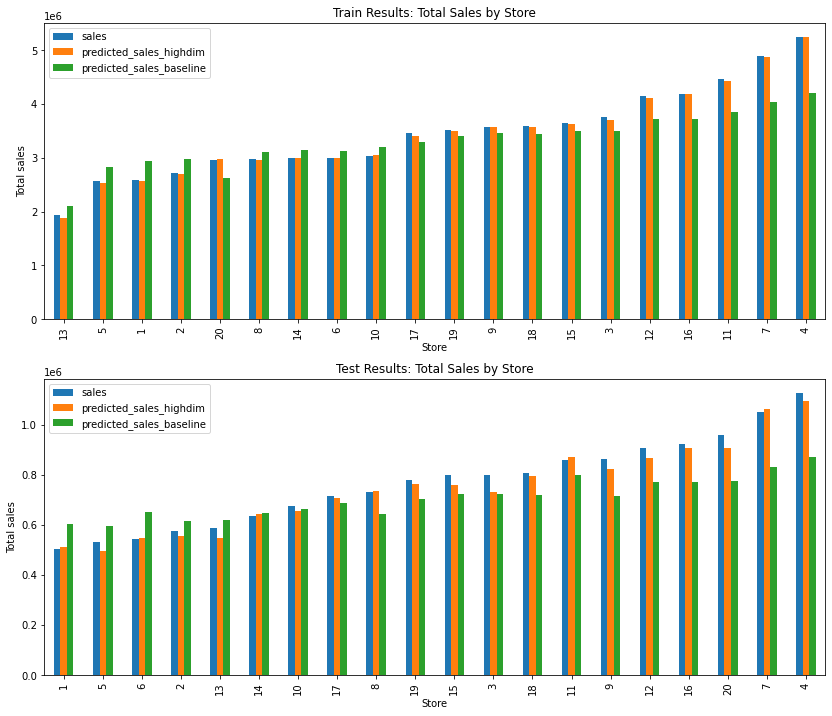

In [13]:
_, axs = plt.subplots(2, 1, figsize=(14, 12))
for i, select in enumerate([select_train, select_val]):
    ax = axs[i]
    df_plot_store = df[select].groupby(
        ["store"]
    ).agg("sum")[sales_cols].reset_index()[:20].sort_values(by="sales")

    df_plot_store.plot.bar(x="store", ax=ax)
    ax.set_xlabel("Store")
    ax.set_ylabel("Total sales")

axs[0].set_title("Train Results: Total Sales by Store")
axs[1].set_title("Test Results: Total Sales by Store")
plt.show()